In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from metrictool import MetricRegressionManager

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
metric_manager = MetricRegressionManager()

## Данные

In [3]:
df = pd.read_csv("Churn_Modelling.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
# Зададим списки признаков
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)), 
            ])
    final_transformers.append((cont_col, cont_transformer))

In [9]:
# Объединим все это в единый пайплайн
feats = FeatureUnion(final_transformers)
# пайплайн, который готовит признаки для моделирования.
feature_processing = Pipeline([('feats', feats)])

## Модели

### RandomForestClassifier

In [10]:
# Обучим модель
from sklearn.ensemble import RandomForestClassifier

model_name = 'RandomForestClassifier'
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [11]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

  Threshold    F-Score    Precision    Recall    Roc-AUC
-----------  ---------  -----------  --------  ---------
      0.380      0.641        0.653     0.629      0.864
Confusion matrix, without normalization


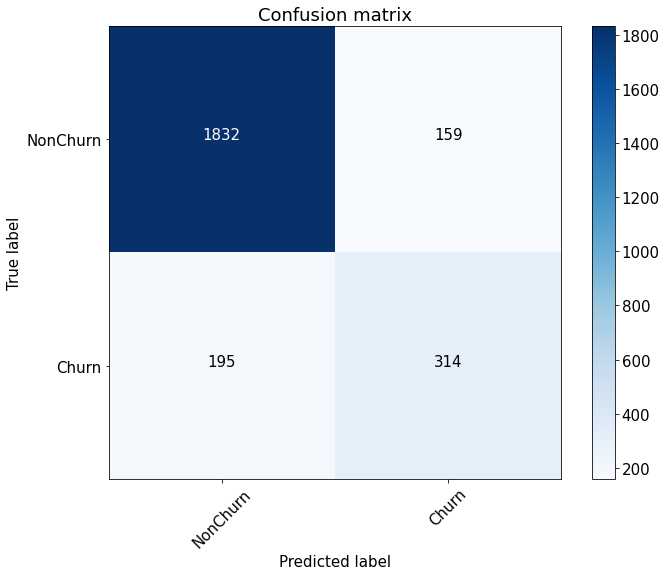

In [12]:
# Строим метрики
# Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, 
# после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - 
# размечаем объект как класс 1, если нет - класс 0)
metric_manager.apply(model_name, y_test, preds)
metric = metric_manager.calc_metric(name=model_name)
metric.show_table()
metric_manager.show_confusion_matrix(model_name)

### Бустинг

In [13]:
%%time
# Тренируем модель
from catboost import CatBoostClassifier

model_name = 'CatBoostClassifier'
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(silent=True, random_state = 42)),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]

Wall time: 11.6 s


  Threshold    F-Score    Precision    Recall    Roc-AUC
-----------  ---------  -----------  --------  ---------
      0.355      0.646        0.641     0.650      0.875
Confusion matrix, without normalization


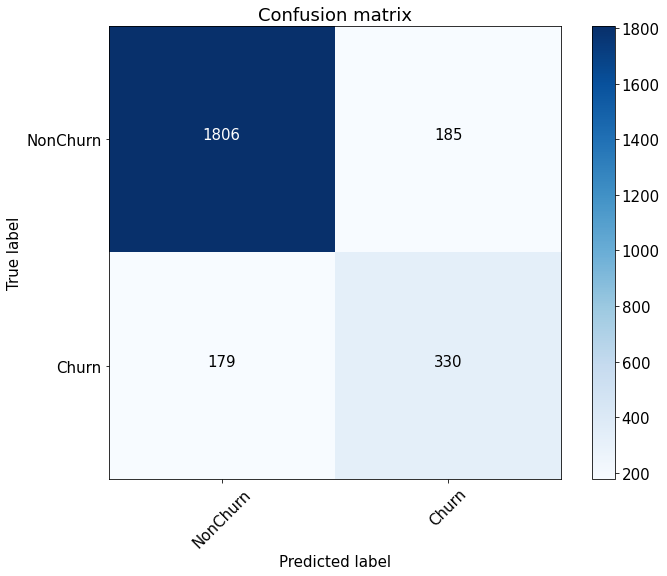

In [14]:
# Строим метрики
metric_manager.apply(model_name, y_test, preds)
metric = metric_manager.calc_metric(name=model_name)
metric.show_table()
metric_manager.show_confusion_matrix(model_name)

### Логическая регрессия

In [15]:
# Нормализация данных
from sklearn.preprocessing import StandardScaler

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class MyStandardScaler(BaseEstimator, TransformerMixin):
    __scaler = None

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        if self.__scaler is None:
            self.__scaler = StandardScaler().fit(X[[self.column]])  
        return self

    def transform(self, X, y=None):
        return self.__scaler.transform(X[[self.column]])

In [16]:
# Делаем Pipeline
# Теперь нам нужно под каждый признак создать трансформер и объединить их в список
final_transformers_v2 = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers_v2.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                    ('selector', NumberSelector(key=cont_col))
                ,   ('scaler', MyStandardScaler(column=cont_col))
                #,   ('scaler', StandardScaler())
            ])
    final_transformers_v2.append((cont_col, cont_transformer))
    
# Объединим все это в единый пайплайн
feats_v2 = FeatureUnion(final_transformers_v2)

In [17]:
# Тренируем модель
from sklearn.linear_model           import LogisticRegression

model_name = 'LogisticRegression'
pipeline = Pipeline([
    ('features',feats_v2),
    ('classifier', LogisticRegression(random_state = 42)),
])
pipeline.fit(X_train, y_train)

y_test_pred = pipeline.predict_proba(X_test)[:, 1]

  Threshold    F-Score    Precision    Recall    Roc-AUC
-----------  ---------  -----------  --------  ---------
      0.290      0.510        0.462     0.568      0.772
Confusion matrix, without normalization


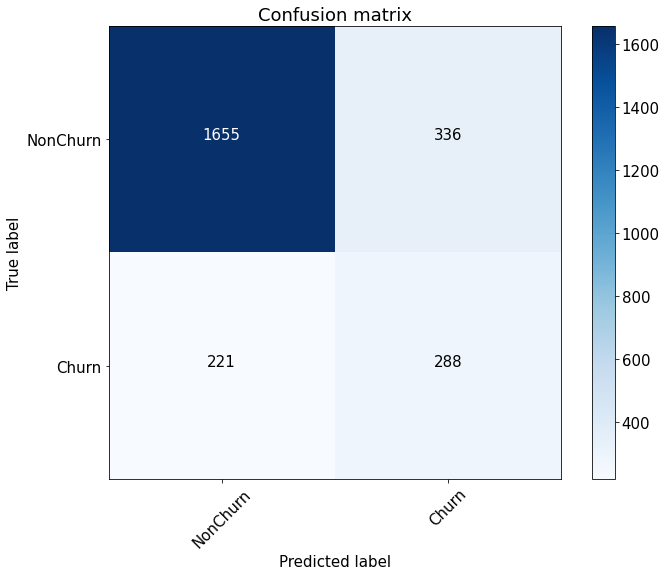

In [18]:
# Строим метрики
metric_manager.apply(model_name, y_test, y_test_pred)
metric = metric_manager.calc_metric(name=model_name)
metric.show_table()
metric_manager.show_confusion_matrix(model_name)

In [19]:
# Смотрим итоговые метрики
metric_manager.calc_metrics()

Name model                Threshold    F-Score    Precision    Recall    Roc-AUC    Profit $
----------------------  -----------  ---------  -----------  --------  ---------  ----------
RandomForestClassifier        0.38       0.641        0.653     0.629      0.864        1673
CatBoostClassifier            0.355      0.646        0.641     0.65       0.875        1621
LogisticRegression            0.29       0.51         0.462     0.568      0.772        1319


По метрикам(f-score) лучшая модель оказалась CatBoostClassifier. Но по прибыльности RandomForestClassifier. Поэтому предпочтение отдадим RandomForestClassifier. Думаю причиной стал Precision. Можно бы было попробовать поэксперементировать с максимизацией Precision и посмотреть как будет менятся Profit